In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tools import lmp_tools as lt
import freud as fr

In [17]:
scratch_loc = '../'

eps_seed = [i for i in range(1,11)]
density_seed = [np.round(0.08 + d * 0.1, 2) for d in range(9)]

def get_oligo_name(eps, density):
    file_pattern = f"without_linker_ves_sizes3_4_5_density{density}_frac0.25_0.5_0.25_eps_attr{eps}_eps_rep1_range0.25_attr_with_repTrue_n_vesicles100"
    scratch_loc = 'Results_span/Results_%s/'%file_pattern
    oligo_name = scratch_loc + 'Oligo_%s.dat'%file_pattern
    return oligo_name

print(get_oligo_name(1,0.08))


Results_span/Results_without_linker_ves_sizes3_4_5_density0.08_frac0.25_0.5_0.25_eps_attr1_eps_rep1_range0.25_attr_with_repTrue_n_vesicles100/Oligo_without_linker_ves_sizes3_4_5_density0.08_frac0.25_0.5_0.25_eps_attr1_eps_rep1_range0.25_attr_with_repTrue_n_vesicles100.dat


Text(0, 0.5, 'Mean Oligomer Size')

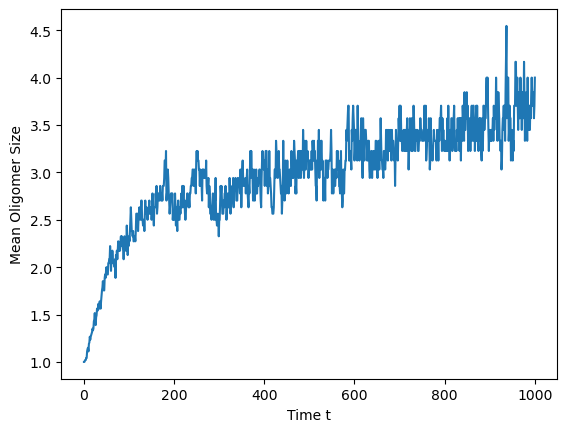

In [20]:
eps = 10
density = 0.98

fig, ax = plt.subplots()

oligo_data = np.genfromtxt(get_oligo_name(eps, density))

x, y = oligo_data[:, 0], oligo_data[:, 1]
ax.plot(x, y)
ax.set_xlabel('Time t')
ax.set_ylabel('Mean Oligomer Size')

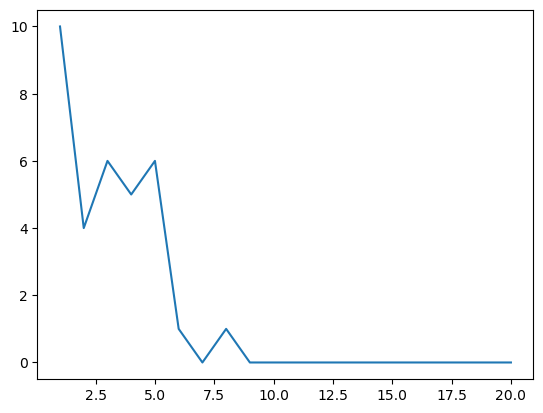

In [12]:
fig, ax= plt.subplots()
max_size_oligo = 20
x, y = o_sizes = np.arange(1,1 + max_size_oligo), oligo_data[-1][2:max_size_oligo + 2]
ax.plot(x, y)

In [13]:
oligo_data.shape

(1001, 402)

In [14]:
oligo_data[:,9].sum()

312.0

In [18]:
mean_oligo_size_main = np.zeros(shape = (len(eps_seed), len(density_seed), 3))

for i in range(len(eps_seed)):  
    for j in range(len(density_seed)):
        eps = eps_seed[i]
        density = density_seed[j]
        
        oligo_name = get_oligo_name(eps, density)
        oligo_data = np.genfromtxt(oligo_name)
        
        time_index = -1 
        #time_averaging
        avg_range = 10
        if len(oligo_data.shape) == 2:
            process_data = oligo_data[:, 1]
            last_data = process_data[-avg_range:]
            mean_oligo_size = np.mean(last_data)
            mean_oligo_size_main[i, j] = eps, density, mean_oligo_size

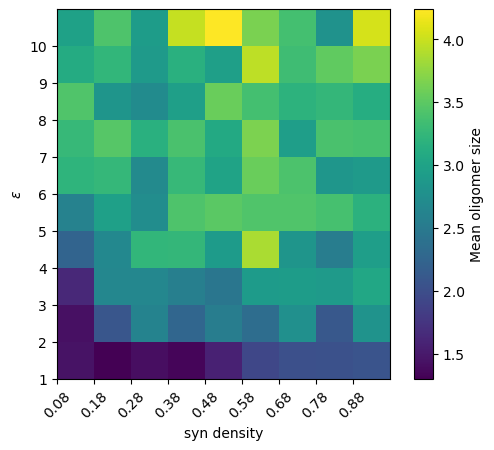

In [19]:
fig, ax = plt.subplots()
array = mean_oligo_size_main[:, :, 2]

y_lims = [np.min(eps_seed), np.max(eps_seed)]
x_lims = [np.min(density_seed), np.max(density_seed)]
tick_freq = [1 , 1]
y_ticks = np.unique(eps_seed)[::tick_freq[0]]
x_ticks = np.unique(density_seed)[::tick_freq[1]]

ax.set_xticks(tick_freq[0]*np.arange(len(x_ticks)))
ax.set_xticklabels(x_ticks, rotation = 45)
ax.set_yticks(tick_freq[1]*np.arange(len(y_ticks)))
ax.set_yticklabels(y_ticks)
ax.set_ylabel(r'$\epsilon$')
ax.set_xlabel(r'syn density')

ax.axes.set_aspect('equal')
cax = ax.pcolormesh(array)
cbar = plt.colorbar(cax, ax=ax, label = 'Mean oligomer size')


In [ ]:
E_tot = e * N_link

In [21]:
class vesicle_analysis(object):
    def __init__(self, movie_name):
        self.movie_name = movie_name
        self.vesicle_type = [1,2,3]

    def sv_cluster_size(self, oligo_file_name, r_cut):
        '''
        This function computes cluster properties of synaptic vesicle clusters.

        '''
        movie_name = self.movie_name
        oligo_file_name

        sv_type = self.vesicle_type

        max_k_mer = 400

        movie_format = ['id', 'type', 'mol', 'x', 'y', 'z']  # structure of the movie data to be loaded
        box_data = np.genfromtxt(movie_name, skip_header=5, max_rows=3)  # grab box data from movie file

        # workingConfig = np.array(pd.read_csv(configName, sep="\s+", names=self.configFormat, header=None, dtype=object))

        read_lines = lt.header_lines(
            movie_name)  ## select or slice from read_lines to load single frames ToDo to be implemented
        work_movie = lt.split_movie(movie_name, movie_format, read_lines)

        box_lens = box_data[:, 1] - box_data[:, 0]
        box = fr.box.Box(box_lens[0], box_lens[1], is2D=True)  # define the box that the freud package can use
        # box.periodic_z = False


        frames_to_process = np.arange(len(work_movie))
        frames_to_process = [-1]

        oligo_dist_time = np.zeros(shape=(len(frames_to_process), max_k_mer + 2))

        for frame in frames_to_process:  # frame to be looked into

            config = work_movie[frame]
            coords = config[:, 3:6]
            
            r = [i in sv_type for i in config[:, 1]]
            lines_sv = np.where(r)[0]

            coords_sv = coords[lines_sv]

            aq = fr.AABBQuery(box, coords_sv)  ## Neighbour query for cluster computation
            # query_result = aq.query(pore_coords, dict(r_max=r_cut))
            # n_list = query_result.toNeighborList()

            cl = fr.cluster.Cluster()  ## create cluster compute object
            cl.compute(aq, neighbors={'r_max': r_cut})
            num_clusters = cl.num_clusters

            cl_prop = fr.cluster.ClusterProperties()
            cl_prop.compute(aq, cl.cluster_idx)

            oligo_dist = np.zeros(shape=max_k_mer + 1)
            mean_oligo_size = np.mean(cl_prop.sizes)
            oligo_dist[0] = mean_oligo_size

            size_dist = np.unique(cl_prop.sizes, return_counts=True)

            np.testing.assert_array_equal(size_dist[0], np.sort(size_dist[0]))
            assert np.max(size_dist[0]) <= max_k_mer
            count_clust = 0
            for i in size_dist[0]:
                oligo_dist[i] = size_dist[1][count_clust]
                count_clust += 1

            max_slice = max_k_mer + 2
            oligo_dist_time[frame, 0] = frame
            oligo_dist_time[frame, 1:max_slice] = oligo_dist

            fig, ax = plt.subplots()
            for cluster_id in range(cl.num_clusters):
            	cluster_system = fr.AABBQuery(aq.box, aq.points[cl.cluster_keys[cluster_id]])
            	cluster_system.plot(ax=ax, s=100, label=f"Cluster {cluster_id}")
#             	print(
#             	f"There are {len(cl.cluster_keys[cluster_id])} points in cluster {cluster_id}."
#             	)
#            ax.set_title(f'$\epsilon$ = {eps}, $N_l$ = {num_linkers}')
            print(mean_oligo_size)
            plt.tight_layout()
#            plt.savefig(f'Plots/clust_plot_{eps}_{num_linkers}.png')
            


2.7777777777777777


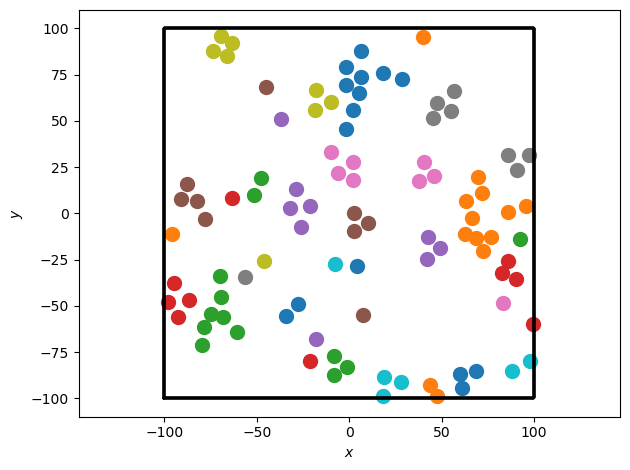

In [27]:
r_cut = 8*1.5
va = vesicle_analysis('Results_span/Results_without_linker_ves_sizes3_4_5_density0.68_frac0.25_0.5_0.25_eps_attr4_eps_rep1_range0.25_attr_with_repTrue_n_vesicles100/Movie_without_linker_ves_sizes3_4_5_frac0.25_0.5_0.25_density0.68_eps_attr4_eps_rep1_range0.25_attr_with_repTrue_n_vesicles100.xyz')
va.sv_cluster_size('test.dat', r_cut)